## Import Libraries

In [ ]:
%tensorflow_version 1.x

import scipy.io
import scipy.signal
import random
import os
from os import environ
import numpy as np
import pandas as pd
import csv
import cv2 
from skimage import color
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.initializers import random_uniform
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from tensorflow.initializers import random_uniform

print("Tensorflow version %s" %tf.__version__)

TensorFlow 1.x selected.
Tensorflow version 1.15.2


Using TensorFlow backend.


## Define data locations

In [ ]:
drive.mount('/content/drive', force_remount=True)

DataDir = '/content/drive/My Drive/Dataset/Recordings/'
LabelsDir = '/content/drive/My Drive/Dataset/Labels/REFERENCE-v3.csv'
imagespath = '/content/drive/My Drive/Neural Network Project/TrainingSet3R/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Custom Functions

In [ ]:
def produce_dataset(Dataset, integer):
    length=len(Dataset)
    Dataset_integer=[]
    for i in range(0, length):
        if Dataset[i][1]==integer:
            Dataset_integer.append([Dataset[i][0], Dataset[i][1]])
    return Dataset_integer

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a

def bandpass_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = scipy.signal.lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = scipy.signal.lfilter(d, c, x)   
    return x
    return y

## Import records and Labels

In [ ]:
mats = []

i=1
for recording in os.listdir(DataDir) :
    mats.append(scipy.io.loadmat(DataDir+str(i)+".mat"))
    i+=1
    if i==100:
        break
     
    
Annotations=pd.read_csv(LabelsDir, names=['label'])
print('Loaded %d labels' %(len(Annotations.label)))

#Encode labels
for i in range (0, len(Annotations)):
    if Annotations.iloc[i][0]=='N':
    Annotations.iloc[i][0]=0
    elif Annotations.iloc[i][0]=='A':
    Annotations.iloc[i][0]=1
    elif Annotations.iloc[i][0]=='O':
    Annotations.iloc[i][0]=2
    elif Annotations.iloc[i][0]=='~':
    Annotations.iloc[i][0]=3     

Loaded 8528 labels


## Generate Dataset

In [ ]:
Dataset=[]
for i in range(0, len(mats)):
    Dataset.append([mats[i], Annotations.iloc[i][0]])

Dataset=np.array(Dataset)

Selected_Dataset=[]
for i in range(0, len(Dataset)):
    if Dataset[i][1]==0:   
    Selected_Dataset.append([Dataset[i][0], Dataset[i][1]])
    elif Dataset[i][1]==1:
    Selected_Dataset.append([Dataset[i][0], Dataset[i][1]])
    elif Dataset[i][1]==2:
    Selected_Dataset.append([Dataset[i][0], Dataset[i][1]])
    elif Dataset[i][1]==3:
    Selected_Dataset.append([Dataset[i][0], Dataset[i][1]])

Selected_Dataset=np.array(Selected_Dataset)  

## Augment Dataset

In [ ]:
Segments=[]
Lenghts=[]
SL=1500
for i in range (0, len(Selected_Dataset)):
    #Define the number of sub-ECGs (lossy approximation)
    N=len(Selected_Dataset[i][0]['val'].flatten())//SL
    #Define the new 'even' lenght of ECGs
    New_len=N*SL
    ECG_modified = Selected_Dataset[i][0]['val'].flatten()[0:New_len]
    #Split the the modified ECGs in N sub-sequences
    ECG_segments = np.split(ECG_modified, N, axis=0)
    Segments.append(ECG_segments)
    #Transform List of lists into NdArray
    ECGs = np.array([np.array(xi) for xi in Segments])


n=0
a=0
r=0
o=0
Augmented_Dataset=[]
for i in range (0, len(ECGs)):
    for j in range (0, len(ECGs[i])):
        #Make sure the dataset is balanced
        if Selected_Dataset[i][1]==0 and n<1000:
            Augmented_Dataset.append([ECGs[i][j], Selected_Dataset[i][1]])
            n+=1
        elif Selected_Dataset[i][1]==1 and a<1000:
            Augmented_Dataset.append([ECGs[i][j], Selected_Dataset[i][1]])
            a+=1
        elif Selected_Dataset[i][1]==2 and o<1000:
            Augmented_Dataset.append([ECGs[i][j], Selected_Dataset[i][1]])
            o+=1
        elif Selected_Dataset[i][1]==3 and r<1000:
            Augmented_Dataset.append([ECGs[i][j], Selected_Dataset[i][1]])
            r+=1  


Dataset_N=produce_dataset(Augmented_Dataset, 0)
Dataset_A=produce_dataset(Augmented_Dataset, 1)
Dataset_O=produce_dataset(Augmented_Dataset, 2)
Dataset_R=produce_dataset(Augmented_Dataset, 3)

## Separate features and labels

In [ ]:
X_train=[]
Y_train=[]

for recordings, label in Dataset_R:
    X_train.append(recordings)
    Y_train.append(label)

X_train=np.array(X_train)

## Pre-process signals

In [ ]:
fs = 300
cutoff_low = 40
cutoff_high = 0.5
order=6
x_train=[]
Max_len_train=[]
for i in range (0, len(X_train)):
    # get rid of floating bias on lead
    running_median = scipy.signal.medfilt(X_train[i], kernel_size=[399])
    ECG = X_train[i] - running_median
    # rescale to same dynamic range
    ECG = 1/np.max(abs(ECG)) * ECG
    # bandpass the signal
    ECG_filtered = bandpass_filter(ECG, fs, order)
    x_train.insert(i, ECG_filtered)

## Plot a random ECG

3


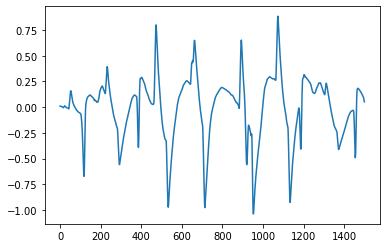

In [ ]:
#Choose a random recording
Sample_number = random.randrange(0, len(x_train))
Sample_lenght = len(x_train[Sample_number])
Sample_annotation = Y_train[Sample_number]

#Build time axis
t=[]
for i in range (0, Sample_lenght):
    t.append(i)

#Plot ECG
plot(t, x_train[Sample_number]);
print(Sample_annotation)

## Generate spectrograms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


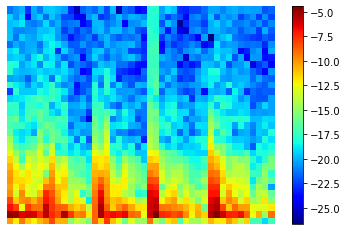

In [ ]:
import matplotlib as mpl

#x_train_spectral=[]
for i in range (0, len(x_train)):
    f, t, Sxx=scipy.signal.spectrogram(x_train[i], fs=300, nperseg=64, noverlap=32)
    Sxx = abs(Sxx)
    mask = Sxx > 0
    Sxx[mask] = np.log(Sxx[mask])
    fig, ax = plt.subplots()
    ax.set_axis_off()
    #ax1.plot(x_train[i]);
    #print(Y_train[i])
    pc = ax.pcolormesh(t, f, Sxx, cmap='jet')
    plt.savefig(imagespath+'A/'+'A'+str(i)+'.png')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    plt.colorbar(pc)